In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML
import scipy
import seaborn as sns
sns.set_style('darkgrid')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "C:/Users/MyWork/PycharmProjects/HW54_DL_PyTorch/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

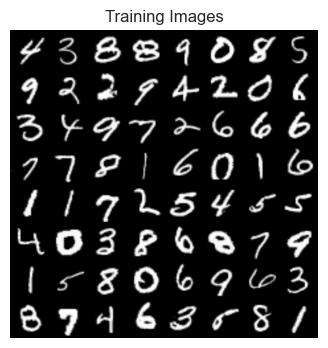

In [3]:
dataset = dset.MNIST(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# dataset

dataIter = iter(dataloader)    # Якою вибіркою пройдемося
trainX, trainY = next(dataIter) # Привласнюємо поточний batch
trainX.shape

torch.Size([128, 1, 64, 64])

In [5]:
trainX.view(-1, 64*64).shape

torch.Size([128, 4096])

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.ReLU(True)
            # state size. ``(nc) x 64 x 64``
        )       

    def forward(self, input):
        return self.main(input)

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# to ``mean=0``, ``stdev=0.02``.

# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
           
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )      
        
    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
#like this: ``to mean=0, stdev=0.2``.

# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)


In [11]:
# Initialize the `CrossEntropyLoss` function
criterion = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [29]:
# Training Loop

device='cpu'

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the trainloader
    for i, data in enumerate(dataloader, 0):
        
    ### D ###
        
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)   
        b_size = real_cpu.size(0)
        
        # Forward pass real batch through D
        output = netD(real_cpu.detach()).view(-1)
        label = torch.full((len(output),), real_label, dtype=torch.float, device=device)   
        
        
                #############################################################################################
                # !!! label = torch.full((b_size,)... було замінено на torch.full((len(output),) - тільки так спрацювало
                # інакше видавало помилку про неспівпадіння розмірів label i output 
                #################################################################################################                
        
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
                   
            
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label.fill_(fake_label)
        
        
                #############################################################################################
                # !!! label = torch.full((b_size,) - а тут все нормально
                #################################################################################################                
        
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

    ### G ###
    
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/2][0/469]	Loss_D: 215929.4375	Loss_G: 621.0603	D(x): -0.0923	D(G(z)): -0.1289 / -0.1287
[0/2][50/469]	Loss_D: 215929.5781	Loss_G: 621.0603	D(x): -0.0901	D(G(z)): -0.1225 / -0.1260
[0/2][100/469]	Loss_D: 215930.0000	Loss_G: 621.0604	D(x): -0.0904	D(G(z)): -0.1258 / -0.1199
[0/2][150/469]	Loss_D: 215929.3906	Loss_G: 621.0602	D(x): -0.0879	D(G(z)): -0.1220 / -0.1203
[0/2][200/469]	Loss_D: 215930.2656	Loss_G: 621.0604	D(x): -0.0884	D(G(z)): -0.1250 / -0.1175
[0/2][250/469]	Loss_D: 215933.0000	Loss_G: 621.0643	D(x): -0.7923	D(G(z)): -1.0245 / -1.0242
[0/2][300/469]	Loss_D: 215932.6562	Loss_G: 621.0620	D(x): -0.7728	D(G(z)): -1.0057 / -1.0072
[0/2][350/469]	Loss_D: 215932.5000	Loss_G: 621.0615	D(x): -0.7643	D(G(z)): -0.9939 / -0.9952
[0/2][400/469]	Loss_D: 215930.7188	Loss_G: 621.0612	D(x): -0.7486	D(G(z)): -0.9844 / -0.9861
[0/2][450/469]	Loss_D: 215930.1094	Loss_G: 621.0610	D(x): -0.7478	D(G(z)): -0.9763 / -0.9776
[1/2][0/469]	Loss_D: 215930.7812	Loss_G: 621.06

In [ ]:



######################################################

Щось не вийшло нормально налаштувати програму. 
Де тут можуть бути помилки?

#######################################################





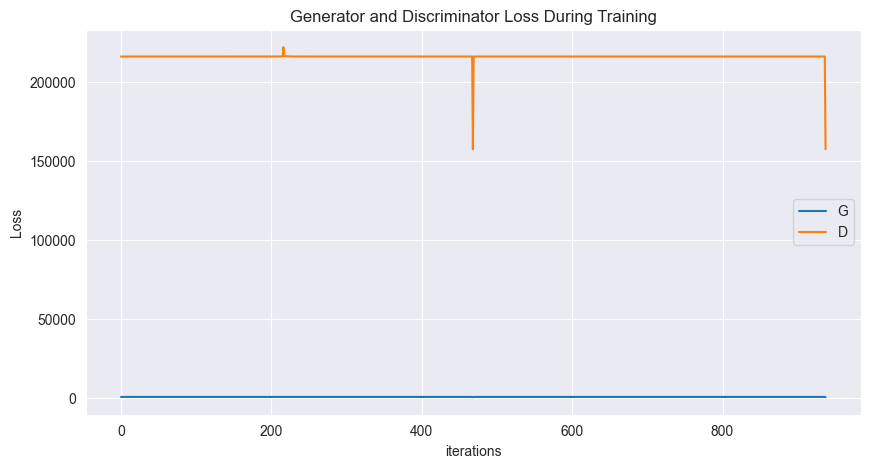

In [30]:
# plot of D & G’s losses versus training iterations

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

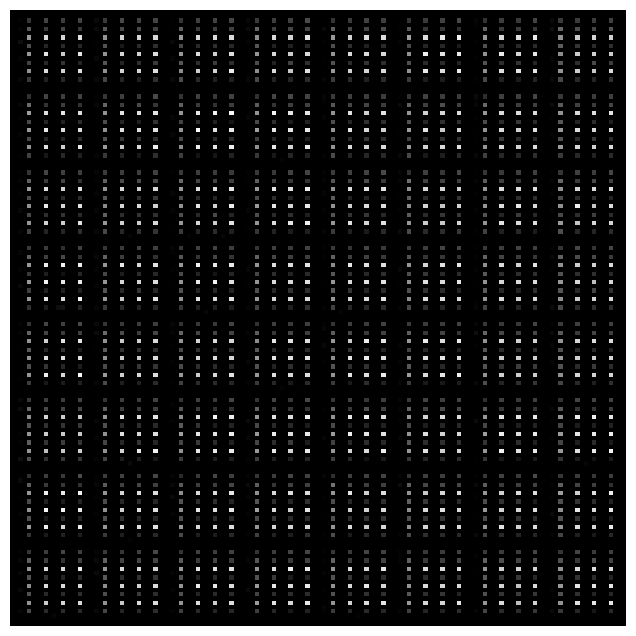

In [33]:
#vvisualization the training progression of G with an animation

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())